In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/FDL21_RaVAEn_datasets/floods.zip" floods.zip
!unzip floods.zip
!rm floods.zip

Archive:  floods.zip
   creating: floods/
   creating: floods/EMSR333_02PORTOPALO/
   creating: floods/EMSR333_02PORTOPALO/changes_vector/
  inflating: floods/EMSR333_02PORTOPALO/changes_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/S2/
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-25.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-20.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-23.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-30.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/
  inflating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/changes/
  inflating: floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/floodmap_edited/
  inflating: floods/EMSR333_02PORTOPALO/floodmap_edited/2018-11-04.geojson  
   creating: floods/EMSR271_02FARKADONA/
  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
import rasterio

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class FloodDataset(nn.Module):
    def __init__(self, patch_size=64):
        super(FloodDataset, self).__init__()
        self.patch_size = patch_size
        self.patches = []
        self.precompute_patches()

    def precompute_patches(self):
        root = os.listdir("/scratch/disc/e.bardet/Simple-VAE-RS/floods")
        for path in root:
            img_paths = [os.path.join("/scratch/disc/e.bardet/Simple-VAE-RS/floods", path, "S2", x) for x in os.listdir(os.path.join("/scratch/disc/e.bardet/Simple-VAE-RS/floods", path, "S2")) if x.endswith(".tif")]
            for img_path in img_paths:
                with rasterio.open(img_path) as src:
                    img = src.read()  # Read all bands
                height, width = img.shape[1], img.shape[2]
                for row in range(0, height, self.patch_size):
                    for col in range(0, width, self.patch_size):
                        if row + self.patch_size <= height and col + self.patch_size <= width:
                            patch = img[:, row:row + self.patch_size, col:col + self.patch_size]
                            quantiles = np.quantile(patch, [0.01, 0.99], axis=(1, 2), keepdims=True)
                            patch = (patch - quantiles[0]) / (quantiles[1] - quantiles[0]+1e-5)
                            patch = np.clip(patch, 0,1)
                            patch = torch.tensor(patch, dtype=torch.float32)
                            if not torch.isnan(patch).any():
                                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


: 

In [ ]:
ds = FloodDataset(patch_size=256)

split = 0.8
train_size = int(split * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=6)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=6)



torch.Size([32, 15, 256, 256])


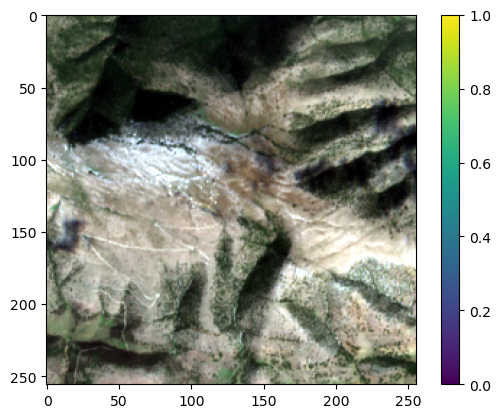

In [ ]:
#Test train_loader
bands = [3,2,1]
data = next(iter(train_loader))
print(data.shape)
plt.imshow(data[0,bands,:,:].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, stride=2, padding=1),  # 4 input channels (
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 input channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64 input channels
            nn.ReLU())
        self.fc_mu = nn.Linear(128 * 8 * 8 *16, self.latent_size)
        self.fc_logvar = nn.Linear(128 * 8 * 8 * 16, self.latent_size)
        self.fc_decode = nn.Linear(self.latent_size, 128 * 8 * 8*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # 128 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 15, kernel_size=8, stride=2, padding=1),  # 32 input channels
            nn.Sigmoid())
        # 4 output channels (same as input)

    def encode(self, x):
        # Define the encoder part of the VAE
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 8*4, 8*4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        # Forward pass through the VAE
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [ ]:
def loss_function(recon_x, x, mu, logvar, gamma):
    # Define the loss function for the VAE
    # Gamma is the variance of the prior
    D = mu.size(1)
    MSE = D*(F.mse_loss(recon_x, x, reduction='sum')/(2*gamma.pow(2)) + (gamma.log()))
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)
    return MSE , KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, gamma, optimizer, epochs):
    t_mse = []
    t_kld = []
    v_mse = []
    v_kld = []
    gamma_vals = []

    for epoch in range(epochs):
        gamma_vals.append(gamma.item())
        model.train()
        train_loss_mse = 0
        train_loss_kld = 0
        train_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
            loss = mse + kld
            train_loss_kld += kld.item()
            train_loss_mse += mse.item()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Append train losses to lists after each epoch
        t_mse.append(train_loss_mse / len(train_loader.dataset))
        t_kld.append(train_loss_kld / len(train_loader.dataset))

        print(f"====> Epoch: {epoch} Average loss: {(train_loss) / len(train_loader.dataset):.4f}")

        val_loss_mse = 0
        val_loss_kld = 0
        val_loss = 0
        for batch_idx ,data in enumerate(val_loader):
            model.eval()
            data = data.to(device)
            with torch.no_grad():
                recon_batch, mu, logvar = model(data)
                mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
                v_loss = mse + kld
                val_loss_kld += kld.item()
                val_loss_mse += mse.item()
                val_loss += v_loss.item()
        # Append val losses to lists after each epoch
        v_mse.append(val_loss_mse / len(val_loader.dataset))
        v_kld.append(val_loss_kld / len(val_loader.dataset))

        print(f"====> Validation loss: {(val_loss) / len(val_loader.dataset):.4f}")

    return t_mse, t_kld, v_mse, v_kld, gamma_vals

In [ ]:
model = VAE(latent_size=4096).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = torch.tensor([1.5]).to(device)
gamma.requires_grad = True
optimizer.add_param_group({'params': gamma})
t_mse, t_kld, v_mse, v_kld, gamma_vals = train(model, train_loader, val_loader, gamma, optimizer, epochs=200)

16it [00:03,  4.24it/s]

====> Epoch: 0 Average loss: 63436044.0000


====> Validation loss: 46978407.0000


16it [00:03,  5.02it/s]

====> Epoch: 1 Average loss: 46280521.7500


====> Validation loss: 43574300.0000


16it [00:03,  5.07it/s]

====> Epoch: 2 Average loss: 42123838.5000


====> Validation loss: 41710762.0000


16it [00:03,  5.03it/s]

====> Epoch: 3 Average loss: 39196454.0000


====> Validation loss: 37106100.0000


16it [00:03,  5.06it/s]

====> Epoch: 4 Average loss: 35214267.6250


====> Validation loss: 33596809.5000


16it [00:03,  5.03it/s]

====> Epoch: 5 Average loss: 31396823.5000


====> Validation loss: 31164126.5000


16it [00:03,  5.03it/s]

====> Epoch: 6 Average loss: 28950944.6250


====> Validation loss: 28634154.5000


16it [00:03,  4.98it/s]

====> Epoch: 7 Average loss: 26590292.6250


====> Validation loss: 26856391.0000


16it [00:03,  4.90it/s]

====> Epoch: 8 Average loss: 24231021.0000


====> Validation loss: 24756641.0000


16it [00:03,  4.98it/s]

====> Epoch: 9 Average loss: 21675610.5000


====> Validation loss: 22778688.0000


16it [00:03,  4.99it/s]

====> Epoch: 10 Average loss: 19282044.7500


====> Validation loss: 20505144.5000


16it [00:03,  4.89it/s]

====> Epoch: 11 Average loss: 17078473.4375


====> Validation loss: 19106654.0000


16it [00:03,  4.96it/s]

====> Epoch: 12 Average loss: 15347533.0625


====> Validation loss: 17483772.2500


16it [00:03,  4.86it/s]

====> Epoch: 13 Average loss: 13963404.6250


====> Validation loss: 16412645.7500


16it [00:03,  4.92it/s]

====> Epoch: 14 Average loss: 12594497.8750


====> Validation loss: 15198386.2500


16it [00:03,  4.85it/s]

====> Epoch: 15 Average loss: 11681132.3750


====> Validation loss: 14430723.2500


16it [00:03,  4.90it/s]

====> Epoch: 16 Average loss: 10877221.0625


====> Validation loss: 13662855.2500


16it [00:03,  4.97it/s]

====> Epoch: 17 Average loss: 10382390.3750


====> Validation loss: 13571764.0000


16it [00:03,  4.90it/s]

====> Epoch: 18 Average loss: 9716523.1875


====> Validation loss: 12766053.2500


16it [00:03,  4.98it/s]

====> Epoch: 19 Average loss: 8942318.6562


====> Validation loss: 12412774.7500


16it [00:03,  4.92it/s]

====> Epoch: 20 Average loss: 8883092.9688


====> Validation loss: 12787661.5000


16it [00:03,  4.94it/s]

====> Epoch: 21 Average loss: 8681488.6250


====> Validation loss: 12320661.5000


16it [00:03,  4.98it/s]

====> Epoch: 22 Average loss: 8099077.2188


====> Validation loss: 11861658.5000


16it [00:03,  4.94it/s]

====> Epoch: 23 Average loss: 7480638.0938


====> Validation loss: 11548633.5000


16it [00:03,  5.02it/s]

====> Epoch: 24 Average loss: 7008337.6562


====> Validation loss: 11261050.0000


16it [00:03,  5.00it/s]

====> Epoch: 25 Average loss: 6648973.2500


====> Validation loss: 11041573.2500


16it [00:03,  5.01it/s]

====> Epoch: 26 Average loss: 6311112.8125


====> Validation loss: 10940871.0000


16it [00:03,  4.81it/s]

====> Epoch: 27 Average loss: 6097369.3750


====> Validation loss: 10934308.2500


16it [00:03,  4.82it/s]

====> Epoch: 28 Average loss: 5962343.0000


====> Validation loss: 10815947.0000


16it [00:03,  4.78it/s]

====> Epoch: 29 Average loss: 5723720.8750


====> Validation loss: 10666941.2500


16it [00:03,  4.78it/s]

====> Epoch: 30 Average loss: 5715057.4062


====> Validation loss: 10671503.7500


16it [00:03,  4.80it/s]

====> Epoch: 31 Average loss: 5584137.7188


====> Validation loss: 10739988.2500


16it [00:03,  4.86it/s]

====> Epoch: 32 Average loss: 5518552.0000


====> Validation loss: 10673163.5000


16it [00:03,  4.92it/s]

====> Epoch: 33 Average loss: 5329033.3125


====> Validation loss: 10507060.7500


16it [00:03,  4.83it/s]

====> Epoch: 34 Average loss: 5070419.7812


====> Validation loss: 10427470.5000


16it [00:03,  4.98it/s]

====> Epoch: 35 Average loss: 4823663.8125


====> Validation loss: 10224118.7500


16it [00:03,  5.00it/s]

====> Epoch: 36 Average loss: 4598092.5625


====> Validation loss: 10157294.5000


16it [00:03,  5.00it/s]

====> Epoch: 37 Average loss: 4448758.5312


====> Validation loss: 10038112.0000


16it [00:03,  4.98it/s]

====> Epoch: 38 Average loss: 4288708.7656


====> Validation loss: 10025874.0000


16it [00:03,  4.94it/s]

====> Epoch: 39 Average loss: 4174046.3906


====> Validation loss: 9935680.5000


16it [00:03,  4.94it/s]

====> Epoch: 40 Average loss: 4008519.8906


====> Validation loss: 9970458.5000


16it [00:03,  4.97it/s]

====> Epoch: 41 Average loss: 3873446.0781


====> Validation loss: 9886099.7500


16it [00:03,  4.94it/s]

====> Epoch: 42 Average loss: 3786172.8125


====> Validation loss: 9882380.7500


16it [00:03,  4.89it/s]

====> Epoch: 43 Average loss: 3727238.2812


====> Validation loss: 9738078.2500


16it [00:03,  4.90it/s]

====> Epoch: 44 Average loss: 3686010.9688


====> Validation loss: 9778333.1250


16it [00:03,  4.77it/s]

====> Epoch: 45 Average loss: 3655584.0000


====> Validation loss: 9707266.5000


16it [00:03,  4.99it/s]

====> Epoch: 46 Average loss: 3663041.3125


====> Validation loss: 9873151.2500


16it [00:03,  4.99it/s]

====> Epoch: 47 Average loss: 3709459.2344


====> Validation loss: 9736161.7500


16it [00:03,  4.93it/s]

====> Epoch: 48 Average loss: 3749913.7031


====> Validation loss: 9815875.0000


16it [00:03,  4.97it/s]

====> Epoch: 49 Average loss: 3758148.8125


====> Validation loss: 9928158.5000


16it [00:03,  4.96it/s]

====> Epoch: 50 Average loss: 3746819.2031


====> Validation loss: 9747412.7500


16it [00:03,  4.97it/s]

====> Epoch: 51 Average loss: 3542278.9062


====> Validation loss: 9598394.5000


16it [00:03,  4.88it/s]

====> Epoch: 52 Average loss: 3357506.3906


====> Validation loss: 9446083.3750


16it [00:03,  4.91it/s]

====> Epoch: 53 Average loss: 3214828.3906


====> Validation loss: 9358471.6250


16it [00:03,  4.97it/s]

====> Epoch: 54 Average loss: 3090344.5469


====> Validation loss: 9329539.3750


16it [00:03,  4.91it/s]

====> Epoch: 55 Average loss: 3020041.9375


====> Validation loss: 9345245.3750


16it [00:03,  4.87it/s]

====> Epoch: 56 Average loss: 2950276.3438


====> Validation loss: 9267689.5000


16it [00:03,  4.96it/s]

====> Epoch: 57 Average loss: 2870595.6094


====> Validation loss: 9294136.8750


16it [00:03,  4.97it/s]

====> Epoch: 58 Average loss: 2806671.0312


====> Validation loss: 9226077.7500


16it [00:03,  4.97it/s]

====> Epoch: 59 Average loss: 2751883.6562


====> Validation loss: 9215469.6250


16it [00:03,  4.91it/s]

====> Epoch: 60 Average loss: 2726052.4531


====> Validation loss: 9133725.2500


16it [00:03,  4.94it/s]

====> Epoch: 61 Average loss: 2698353.1250


====> Validation loss: 9109664.2500


16it [00:03,  4.92it/s]

====> Epoch: 62 Average loss: 2680071.0938


====> Validation loss: 9121202.1250


16it [00:03,  4.93it/s]

====> Epoch: 63 Average loss: 2660602.4688


====> Validation loss: 9185492.3750


16it [00:03,  4.92it/s]

====> Epoch: 64 Average loss: 2709053.0938


====> Validation loss: 9032517.0000


16it [00:03,  4.79it/s]

====> Epoch: 65 Average loss: 2798321.3281


====> Validation loss: 9177938.0000


16it [00:03,  4.91it/s]

====> Epoch: 66 Average loss: 2760915.4531


====> Validation loss: 9112606.8750


16it [00:03,  4.89it/s]

====> Epoch: 67 Average loss: 2743921.9688


====> Validation loss: 9120166.1250


16it [00:03,  4.92it/s]

====> Epoch: 68 Average loss: 2724138.1719


====> Validation loss: 8994156.7500


16it [00:03,  4.96it/s]

====> Epoch: 69 Average loss: 2695667.1094


====> Validation loss: 9058850.8750


16it [00:03,  4.97it/s]

====> Epoch: 70 Average loss: 2649236.2031


====> Validation loss: 8927328.3750


16it [00:03,  4.86it/s]

====> Epoch: 71 Average loss: 2535543.6875


====> Validation loss: 8811997.0000


16it [00:03,  4.74it/s]

====> Epoch: 72 Average loss: 2432857.8750


====> Validation loss: 8803204.1250


16it [00:03,  4.95it/s]

====> Epoch: 73 Average loss: 2382348.7812


====> Validation loss: 8801696.6250


16it [00:03,  4.84it/s]

====> Epoch: 74 Average loss: 2324372.5781


====> Validation loss: 8745267.5000


16it [00:03,  4.85it/s]

====> Epoch: 75 Average loss: 2333127.4531


====> Validation loss: 8765161.2500


16it [00:03,  4.88it/s]

====> Epoch: 76 Average loss: 2312700.4922


====> Validation loss: 8769333.0000


16it [00:03,  4.97it/s]

====> Epoch: 77 Average loss: 2272566.3750


====> Validation loss: 8716679.3750


16it [00:03,  4.99it/s]

====> Epoch: 78 Average loss: 2242276.3594


====> Validation loss: 8710937.6250


16it [00:03,  4.86it/s]

====> Epoch: 79 Average loss: 2248002.1250


====> Validation loss: 8612684.1250


16it [00:03,  4.95it/s]

====> Epoch: 80 Average loss: 2237607.0078


====> Validation loss: 8646921.5000


16it [00:03,  4.97it/s]

====> Epoch: 81 Average loss: 2214051.3828


====> Validation loss: 8529987.1250


16it [00:03,  4.95it/s]

====> Epoch: 82 Average loss: 2187596.7656


====> Validation loss: 8550439.7500


16it [00:03,  5.01it/s]

====> Epoch: 83 Average loss: 2179114.5234


====> Validation loss: 8511290.7500


16it [00:03,  4.87it/s]

====> Epoch: 84 Average loss: 2140766.0469


====> Validation loss: 8489532.7500


16it [00:03,  4.97it/s]

====> Epoch: 85 Average loss: 2087873.6875


====> Validation loss: 8469902.0000


16it [00:03,  4.88it/s]

====> Epoch: 86 Average loss: 2034727.0859


====> Validation loss: 8411035.1250


16it [00:03,  4.90it/s]

====> Epoch: 87 Average loss: 2012706.0312


====> Validation loss: 8375187.3750


16it [00:03,  4.93it/s]

====> Epoch: 88 Average loss: 2026950.3047


====> Validation loss: 8392819.8750


16it [00:03,  4.91it/s]

====> Epoch: 89 Average loss: 2106805.5781


====> Validation loss: 8363032.7500


16it [00:03,  4.89it/s]

====> Epoch: 90 Average loss: 2123654.6562


====> Validation loss: 8382641.5000


16it [00:03,  4.99it/s]

====> Epoch: 91 Average loss: 2422815.9062


====> Validation loss: 9041025.5000


16it [00:03,  4.94it/s]

====> Epoch: 92 Average loss: 2697112.9062


====> Validation loss: 8474773.0000


16it [00:03,  4.94it/s]

====> Epoch: 93 Average loss: 2493060.3125


====> Validation loss: 8447255.3750


16it [00:03,  4.96it/s]

====> Epoch: 94 Average loss: 2268685.2812


====> Validation loss: 8383665.2500


16it [00:03,  4.96it/s]

====> Epoch: 95 Average loss: 2108590.1172


====> Validation loss: 8199295.8750


16it [00:03,  4.96it/s]

====> Epoch: 96 Average loss: 1974647.8438


====> Validation loss: 8156721.8750


16it [00:03,  4.88it/s]

====> Epoch: 97 Average loss: 1901255.1562


====> Validation loss: 8114320.6250


16it [00:03,  4.93it/s]

====> Epoch: 98 Average loss: 1849753.4375


====> Validation loss: 8110937.6250


16it [00:03,  4.88it/s]

====> Epoch: 99 Average loss: 1809794.8203


====> Validation loss: 8096509.8750


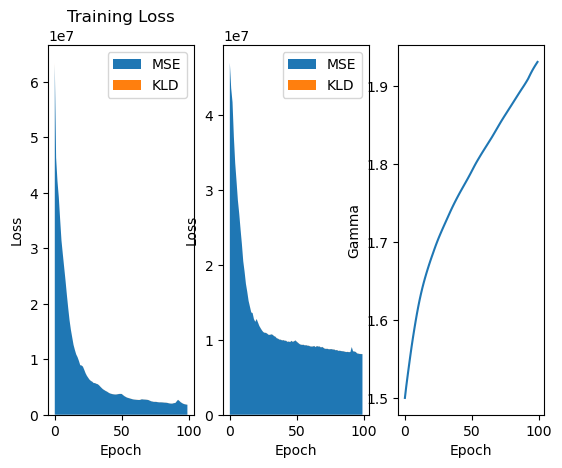

In [ ]:
plt.subplot(1,3,1)
plt.stackplot(range(len(t_mse)), t_mse, t_kld, labels=['MSE', 'KLD'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1,3,2)
plt.stackplot(range(len(v_mse)), v_mse, v_kld, labels=['MSE', 'KLD'])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,3,3)
plt.plot(gamma_vals)
plt.xlabel('Epoch')
plt.ylabel('Gamma')
plt.show()


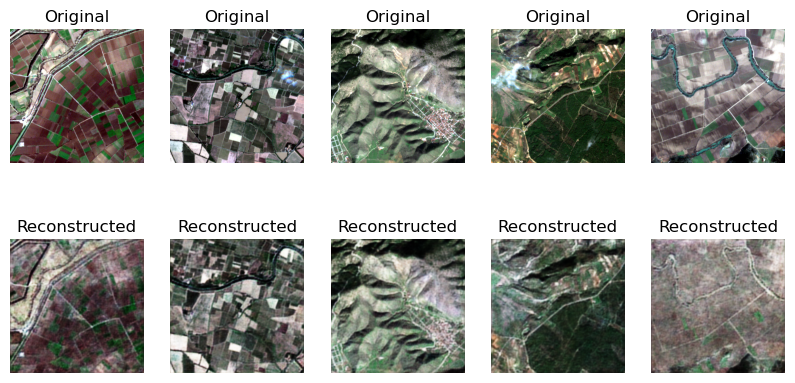

In [ ]:
data = next(iter(val_loader))

data = data.to(device)
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.cpu().detach().numpy()
data = data.cpu().detach().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon_batch[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()



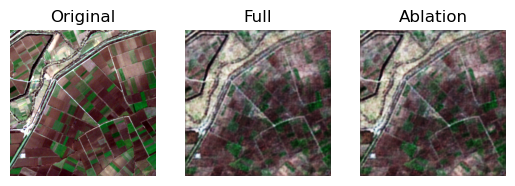

In [ ]:
torch.cuda.empty_cache()
mu, logvar = model.encode(torch.Tensor(data[0:1]).to(device))
import numpy as np
mu, logvar = mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()
# Generate batch without ablation
z_no_ablation = torch.Tensor(np.random.normal(loc=mu, scale=np.exp(logvar), size=(500,4096))).to(device)

recon_no_ablation = model.decode(z_no_ablation)
recon_no_ablation = recon_no_ablation.cpu().detach().numpy()


z_no_ablation = z_no_ablation.cpu()
z_ablation = torch.Tensor(z_no_ablation).clone().to(device)
del z_no_ablation

# Generate batch with ablation
z_ablation[:, 64:127] = 0
z_ablation = z_ablation.to(device)
recon_ablation = model.decode(z_ablation)
recon_ablation = recon_ablation.cpu().detach().numpy()

plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Full")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Ablation")
plt.axis('off')

plt.show()


err_map = np.var(data[0:1] - recon_no_ablation, axis=0)
err_map = np.mean(err_map, axis=0)

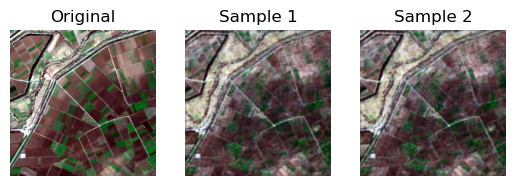

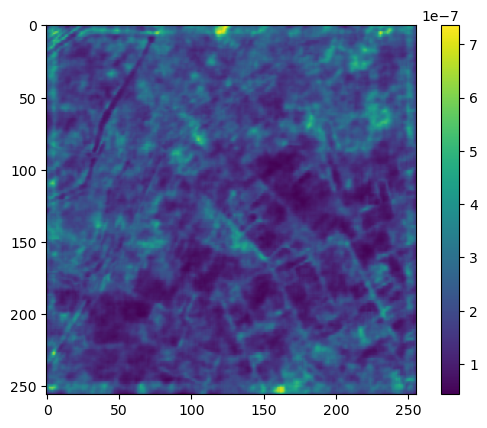

In [ ]:
plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_no_ablation[1,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 2")
plt.axis('off')

plt.show()

plt.imshow(err_map)
plt.colorbar()
plt.show()

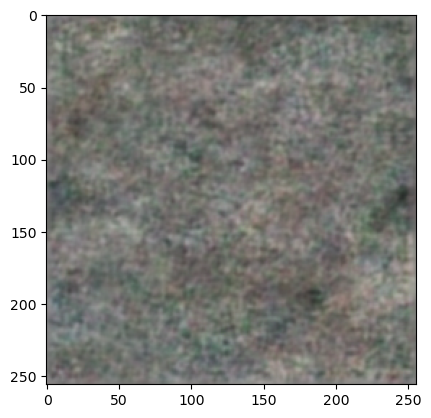

In [ ]:
z_sample = torch.Tensor(np.random.randn(1,4096)).to(device)
decod = model.decode(z_sample)

plt.imshow(decod[0,bands,:,:].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()